In [1]:
%matplotlib inline
import datacube

In [2]:
import numpy as np

In [3]:
dc = datacube.Datacube()

# Load Sentinel-1 data

In [4]:
query = {
'y': (-35.217575569215505, -34.97543887925878), 
'x': (149.2719268798828, 149.5095062255859),
'time':('2017-01-01','2018-01-01'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (30, -30)
}

In [5]:
radar = dc.load(product='s1_gamma0_geotif_scene', **query)

# Select scenes covering lake George

In [6]:
total_px=len(radar.x)*len(radar.y)

In [7]:
valid=radar.where(radar.vv!=0).where(radar.vh!=0).count(dim=('x','y'))

In [8]:
good=(valid.vh/total_px)>0.5
good.sum()

<xarray.DataArray 'vh' ()>
array(27)

In [9]:
radar_lake = radar.sel(time=good)

In [10]:
# replace 0 with nan
radar_lake_clean = radar_lake.where(radar_lake!=0)

# Apply speckle filter

In [11]:
# Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(da, size):
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [12]:
# lee filter implemnation doesn't consider nan

# save the nodata mask
nodata_mask = radar_lake_clean.isnull().to_array().any(axis=0)
# replace nan with 0
radar_lake_zerofilled = radar_lake.where(~radar_lake.isnull(), 0)

In [13]:
smoothed_vv=radar_lake_zerofilled.vv.groupby('time').apply(lee_filter, size=7)
smoothed_vh=radar_lake_zerofilled.vh.groupby('time').apply(lee_filter, size=7)

In [14]:
smoothed=smoothed_vv.to_dataset(name='vv')
smoothed['vh']=smoothed_vh

In [15]:
# put nodata back
smoothed=smoothed.where(~nodata_mask)

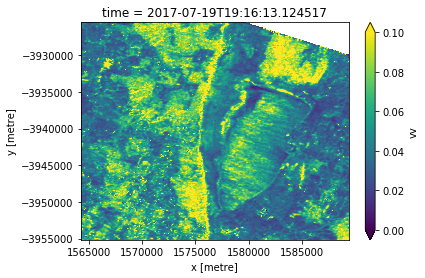

In [16]:
smoothed.isel(time=14).vv.plot(vmin=0,vmax=0.1)

In [17]:
# alternative quick mean filter
smoothed_mean = radar_lake_clean.rolling(x=7).mean().rolling(y=7).mean()

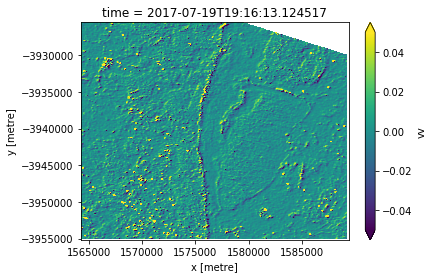

In [18]:
# visible difference on edge of features and for narrow features
(smoothed_mean.isel(time=14).vv-smoothed.isel(time=14).vv).plot(vmin=-0.05, vmax=0.05)

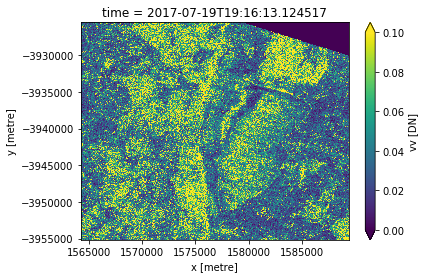

In [19]:
# speckled image before filtering
radar_lake.isel(time=14).vv.plot(vmin=0,vmax=0.1)

# Replace 0 with nan and negative with a small value

In [20]:
clean=smoothed.copy()
clean['vv'] =clean.vv.where(~clean.vv.isnull(), 1000)
clean['vh'] =clean.vh.where(~clean.vh.isnull(), 1000)
print("# of negative pixels in vv vh:", (clean.vv<0).sum().values, (clean.vh<0).sum().values)
#visual check
#(clean.vh<0).any(dim='time').plot()
clean['vv'] =clean.vv.where(clean.vv>0, 1e-3)
clean['vh'] =clean.vh.where(clean.vh>0, 1e-4)
clean=clean.where(clean<1000)

# of negative pixels in vv vh: 307 96


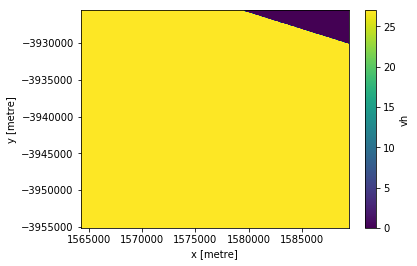

In [21]:
# number of valid observations
clean.vh.count(dim='time').plot()

# Add vv+vh, vh/vv

In [22]:
clean['vv_plus_vh']=clean.vh+clean.vv
clean['vh_over_vv']=clean.vh/clean.vv

In [23]:
clean

<xarray.Dataset>
Dimensions:     (time: 27, x: 836, y: 988)
Coordinates:
  * y           (y) float64 -3.955e+06 -3.955e+06 -3.955e+06 -3.955e+06 ...
  * x           (x) float64 1.589e+06 1.589e+06 1.589e+06 1.589e+06 ...
  * time        (time) datetime64[ns] 2017-01-08T19:16:07.759542 ...
Data variables:
    vv          (time, y, x) float32 0.12148778 0.11465964 0.10796056 ...
    vh          (time, y, x) float32 0.033485994 0.056191128 0.029323746 ...
    vv_plus_vh  (time, y, x) float32 0.15497378 0.17085077 0.13728431 ...
    vh_over_vv  (time, y, x) float32 0.27563262 0.49006894 0.27161536 ...

# Use histograms to find optimal separation of water and nonwater

In [24]:
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

In [25]:
import numpy as np
from scipy.signal import argrelextrema


def find_optimal_minimum(hist, hist_x, min_valid=0.008, max_valid=0.03, min_perc=0.1, min_contrast=1.6):
    minima= hist_x[argrelextrema(hist, np.less, order=1)]
    maxima= hist_x[argrelextrema(hist, np.greater, order=1)]
    # no minima or maxima found
    if len(minima)==0 or len(maxima)==0: return None
    # minima not in approprite range
    if minima.max() < min_valid or minima.min() > max_valid: return None
    minima=minima[minima>=min_valid]
    minima=minima[minima<=max_valid]
    # find minimum with largest contrast
    contrast=0
    best_m=None
    hist_maxima=hist[argrelextrema(hist, np.greater, order= 1)]
    for m in minima:
        # has to have a maximum on lower side
        lower_peaks=hist_maxima[maxima<m]
        if len(lower_peaks)==0: continue
        # has to have more than min_perc below threshold
        # note the histograms don't extend full range of values, so 0.1 means much less than 10% overall
        # this can potentially be constrained from minimum extent from wofs
        if hist[:np.where(hist_x==m)[0][0]+1].sum()/hist.sum()<min_perc: continue
        low=hist[np.where(hist_x==m)[0]][0]    
        this_contrast=lower_peaks.max()/low
        if this_contrast>contrast:
            contrast=this_contrast
            best_m=m
    if best_m is None or contrast<min_contrast: return None
    return hist_x[np.where(hist_x==best_m)[0]+1][0]  # right boundary


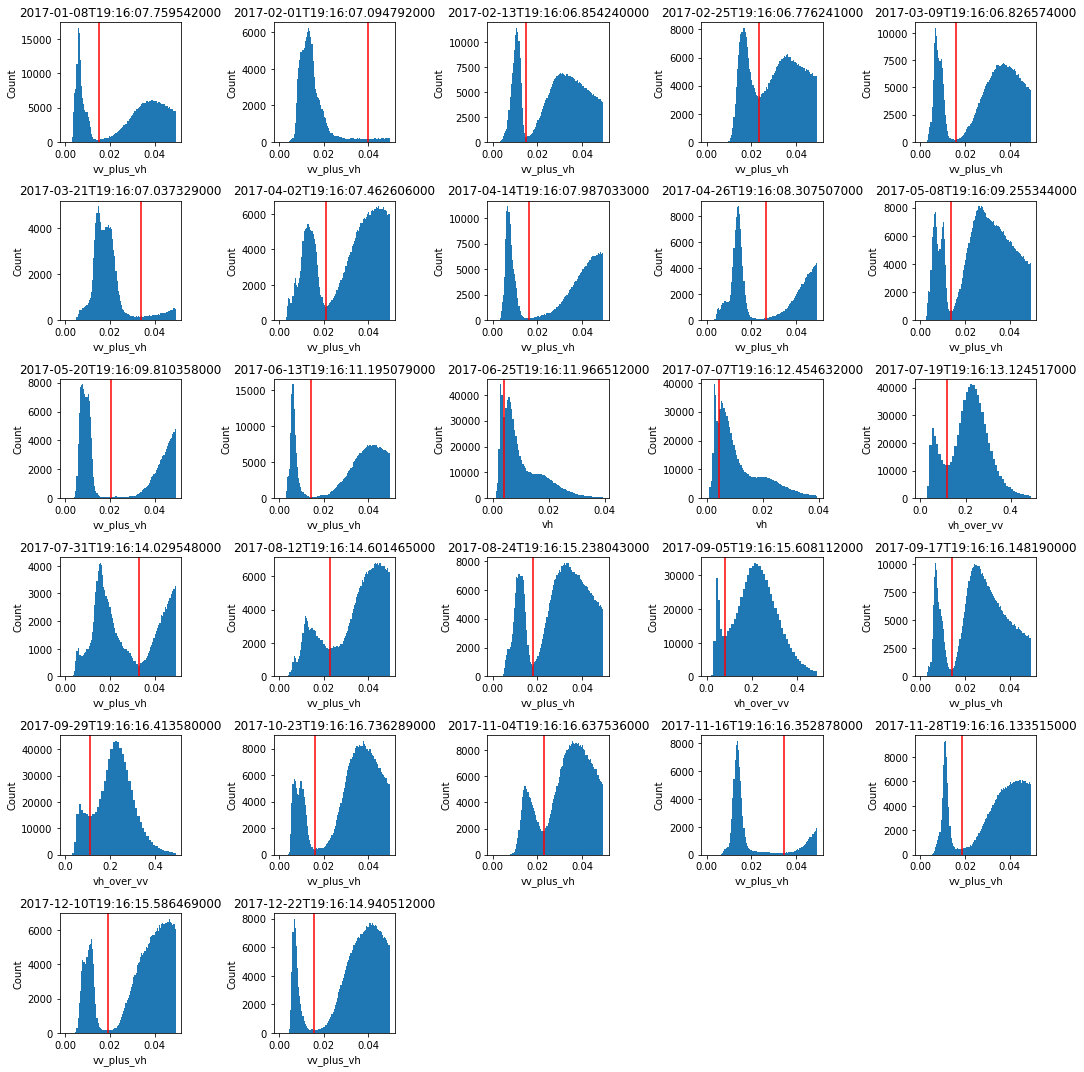

In [26]:
f=plt.figure(figsize=(15,15))
ntime=len(clean.time.values)
ncol=5
nrow=int(np.ceil(ntime*1./ncol))
gs=GridSpec(nrow, ncol)

water=np.zeros_like(clean.vv)

for i in range(ntime):
    ax=f.add_subplot(gs[i])
    # vv+vh provides best separation in general
    hist, hist_x, t=clean.vv_plus_vh.isel(time=i).plot.hist(bins=np.arange(0.0,0.05,0.0005))
    minima= find_optimal_minimum(hist, hist_x, min_valid=0.005, max_valid=0.04, min_contrast=1.6)
    found = False
    if minima is not None:
        water[i,:,:]=clean.vv_plus_vh.isel(time=i) <= minima
        ax.axvline(minima, color='r')
        found = True
    if not found:
        ax.clear()
        hist, hist_x, t=clean.vh_over_vv.isel(time=i).plot.hist(bins=np.arange(0.0,0.5,0.01))
        minima= find_optimal_minimum(hist, hist_x, min_valid=0.01, max_valid=0.3, min_contrast=1.3)
        if minima is not None:
            water[i,:,:]=clean.vh_over_vv.isel(time=i) <= minima
            ax.axvline(minima, color='r')
            found = True
    if not found:
        ax.clear()
        hist, hist_x, t=clean.vh.isel(time=i).plot.hist(bins=np.arange(0.0,0.04,0.0005))
        minima= find_optimal_minimum(hist, hist_x, min_valid=0.002, max_valid=0.01, min_contrast=1.3)
        if minima is not None:
            water[i,:,:]=clean.vh.isel(time=i) <= minima
            ax.axvline(minima, color='r')
    ax.set_title(clean.time.values[i])
f.tight_layout()

In [27]:
clean['wofs'] = ('time','y','x'), water

In [28]:
clean['wofs'] = clean.wofs.where(~clean.vh.isnull()).where(~clean.vv.isnull())
clean

<xarray.Dataset>
Dimensions:     (time: 27, x: 836, y: 988)
Coordinates:
  * y           (y) float64 -3.955e+06 -3.955e+06 -3.955e+06 -3.955e+06 ...
  * x           (x) float64 1.589e+06 1.589e+06 1.589e+06 1.589e+06 ...
  * time        (time) datetime64[ns] 2017-01-08T19:16:07.759542 ...
Data variables:
    vv          (time, y, x) float32 0.12148778 0.11465964 0.10796056 ...
    vh          (time, y, x) float32 0.033485994 0.056191128 0.029323746 ...
    vv_plus_vh  (time, y, x) float32 0.15497378 0.17085077 0.13728431 ...
    vh_over_vv  (time, y, x) float32 0.27563262 0.49006894 0.27161536 ...
    wofs        (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

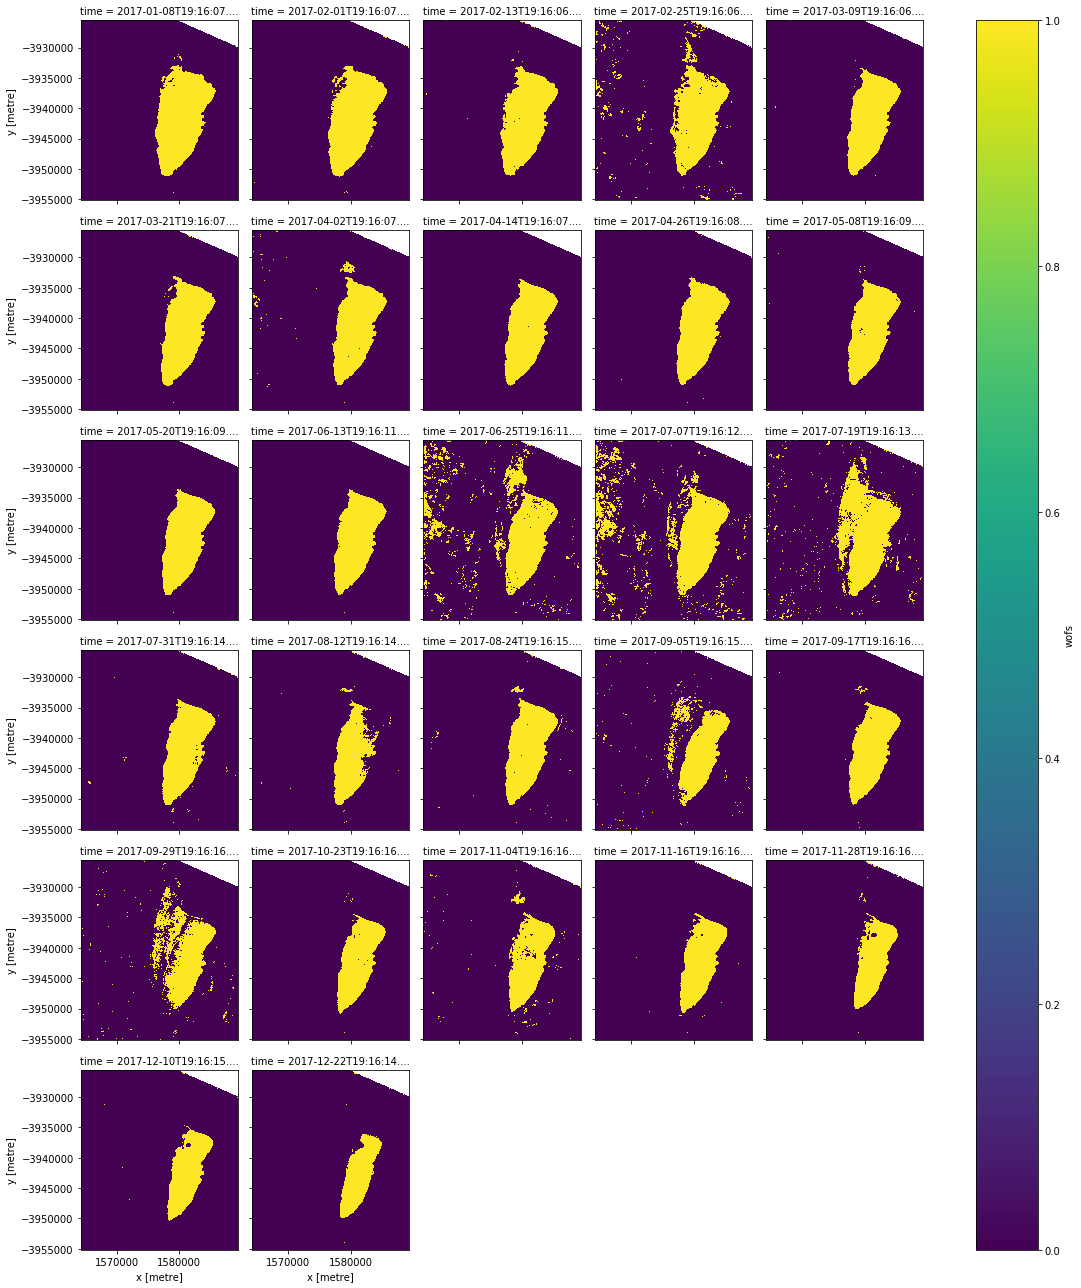

In [29]:
clean.wofs.plot(col='time',col_wrap=5)

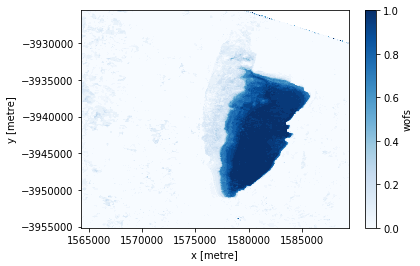

In [30]:
#summary 
clean.wofs.mean(dim='time').plot(cmap='Blues')

# Save output to file

In [31]:
import os

outputfile = 'output/netcdfs/sentinel_1_gamma/s1_water_v2.nc'
if os.path.exists(outputfile): os.remove(outputfile)

In [32]:
water=clean.wofs.to_dataset(name='wofs')
dataset_to_output =  water.assign_attrs(radar.attrs)
datacube.storage.storage.write_dataset_to_netcdf(dataset_to_output, outputfile)

# Load WOFS annual summary for comparison

In [33]:
wofs=dc.load(product='wofs_annual_summary', **query)

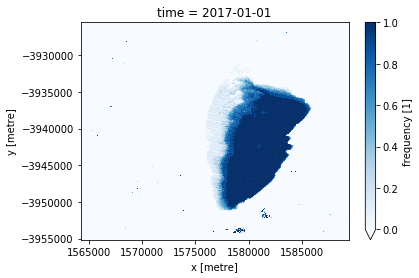

In [34]:
wofs.isel(time=0).frequency.plot(cmap='Blues', vmin=0, vmax=1)

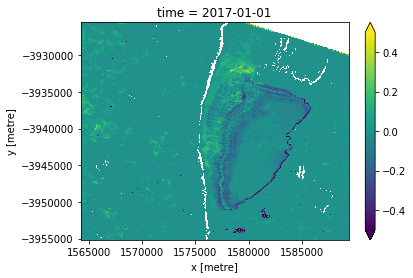

In [35]:
# difference between S1 and Landsat wofs
wofs_freq=wofs.isel(time=0).frequency
wofs_freq=wofs_freq.where(wofs_freq>=0)
(clean.wofs.mean(dim='time')-wofs_freq).plot(vmin=-0.5, vmax=0.5)

In [36]:
min_extent=(wofs.isel(time=0).frequency==1).where(wofs.isel(time=0).frequency,0).sum()
print(min_extent, min_extent/(~clean.vv.isnull().isel(time=0)).sum())

<xarray.DataArray 'frequency' ()>
array(72071)
Coordinates:
    time     datetime64[ns] 2017-01-01 <xarray.DataArray ()>
array(0.089938)


# Find maximum extent of lake

In [37]:
from rasterio import features
from shapely.geometry import shape

def find_largest_water(wofs):
    max_water = 0
    for fshape, value in features.shapes((wofs>0).values.astype('int16'), mask=(wofs>0).values):
        geom=shape(fshape)
        if geom.area>max_water:
            max_water = geom.area
            water_body = geom
    return water_body

lake = find_largest_water(wofs.frequency)

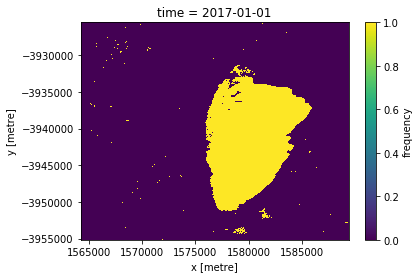

In [38]:
(wofs.frequency>0.).plot()

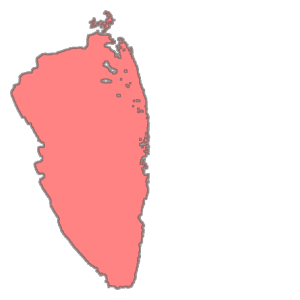

In [40]:
lake